In [1]:
!pip install matplotlib numpy pandas seaborn

  Using cached matplotlib-3.10.6-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached matplotlib-3.10.6-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention_heatmap(attention_weights, s1_tokens=None, s2_tokens=None, title="Attention Heatmap", save_path=None):
    """
    Visualize attention weights as a heatmap
    
    Args:
        attention_weights: Tensor of shape [batch_size, num_heads, seq_len1, seq_len2]
        s1_tokens: List of tokens for the first sequence (optional)
        s2_tokens: List of tokens for the second sequence (optional)
        title: Title for the plot
        save_path: Path to save the plot (optional)
    """
    # Average over all heads if multi-head attention
    if len(attention_weights.shape) == 4:  # [batch, heads, seq1, seq2]
        attention_weights = attention_weights.mean(dim=1)  # Average over heads
    
    # Take first batch if batched
    if len(attention_weights.shape) == 3:  # [batch, seq1, seq2]
        attention_weights = attention_weights[0]
    
    attention_weights = attention_weights.cpu().detach().numpy()
    
    plt.figure(figsize=(12, 8))
    
    # Create heatmap
    ax = sns.heatmap(
        attention_weights,
        xticklabels=s2_tokens if s2_tokens else [f"Img_{i}" for i in range(attention_weights.shape[1])],
        yticklabels=s1_tokens if s1_tokens else [f"Txt_{i}" for i in range(attention_weights.shape[0])],
        cmap='viridis',
        cbar_kws={'label': 'Attention Weight'}
    )
    
    plt.title(title)
    plt.xlabel('Image Patches')
    plt.ylabel('Text Tokens')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def get_attention_weights(model, input_ids, segment_ids, input_mask, added_attention_mask, 
                         visual_embeds_mean, visual_embeds_att, trans_matrix, 
                         image_decode=None, alpha=None, beta=None, theta=None, sigma=None, 
                         temp=None, temp_lamb=None, labels=None, auxlabels=None):
    """
    Get attention weights from img2txt_attention module
    """
    # Get the emission scores from the BiLSTM
    features = model.roberta(input_ids, token_type_ids=segment_ids, attention_mask=input_mask)
    sequence_output = features["last_hidden_state"]
    pooler_output = features["pooler_output"]
    sequence_output = model.dropout(sequence_output)
    pooler_output = model.linear(pooler_output)

    extended_txt_mask = input_mask.unsqueeze(1).unsqueeze(2)
    extended_txt_mask = extended_txt_mask.to(dtype=next(model.parameters()).dtype)
    extended_txt_mask = (1.0 - extended_txt_mask) * -10000.0
    aux_addon_sequence_encoder = model.self_attention(sequence_output, extended_txt_mask)

    aux_addon_sequence_output = aux_addon_sequence_encoder[-1]
    aux_addon_sequence_output = aux_addon_sequence_output[0]

    main_addon_sequence_encoder = model.self_attention_v2(sequence_output, extended_txt_mask)
    main_addon_sequence_output = main_addon_sequence_encoder[-1]
    main_addon_sequence_output = main_addon_sequence_output[0]
    
    vis_embed_map = visual_embeds_att.view(-1, 2048, 49).permute(0, 2, 1)
    converted_vis_embed_map = model.vismap2text(vis_embed_map)

    # Apply txt2img attention mechanism
    img_mask = added_attention_mask[:,:49]
    extended_img_mask = img_mask.unsqueeze(1).unsqueeze(2)
    extended_img_mask = extended_img_mask.to(dtype=next(model.parameters()).dtype)
    extended_img_mask = (1.0 - extended_img_mask) * -10000.0

    cross_encoder = model.txt2img_attention(main_addon_sequence_output, converted_vis_embed_map, extended_img_mask)
    cross_output_layer = cross_encoder[-1]

    # Get attention weights from img2txt_attention
    converted_vis_embed_map_v2 = model.vismap2text_v2(vis_embed_map)
    
    # Modify the forward call to get attention weights
    cross_txt_encoder, attention_weights = model.img2txt_attention(
        converted_vis_embed_map_v2, main_addon_sequence_output, extended_txt_mask, 
        output_attentions=True
    )
    cross_txt_output_layer = cross_txt_encoder[-1]
    
    return attention_weights  # List of attention weights for each layer

/home/vms/miniconda3/envs/mner/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Valid image patches: 49/49
Valid text tokens: 23/25


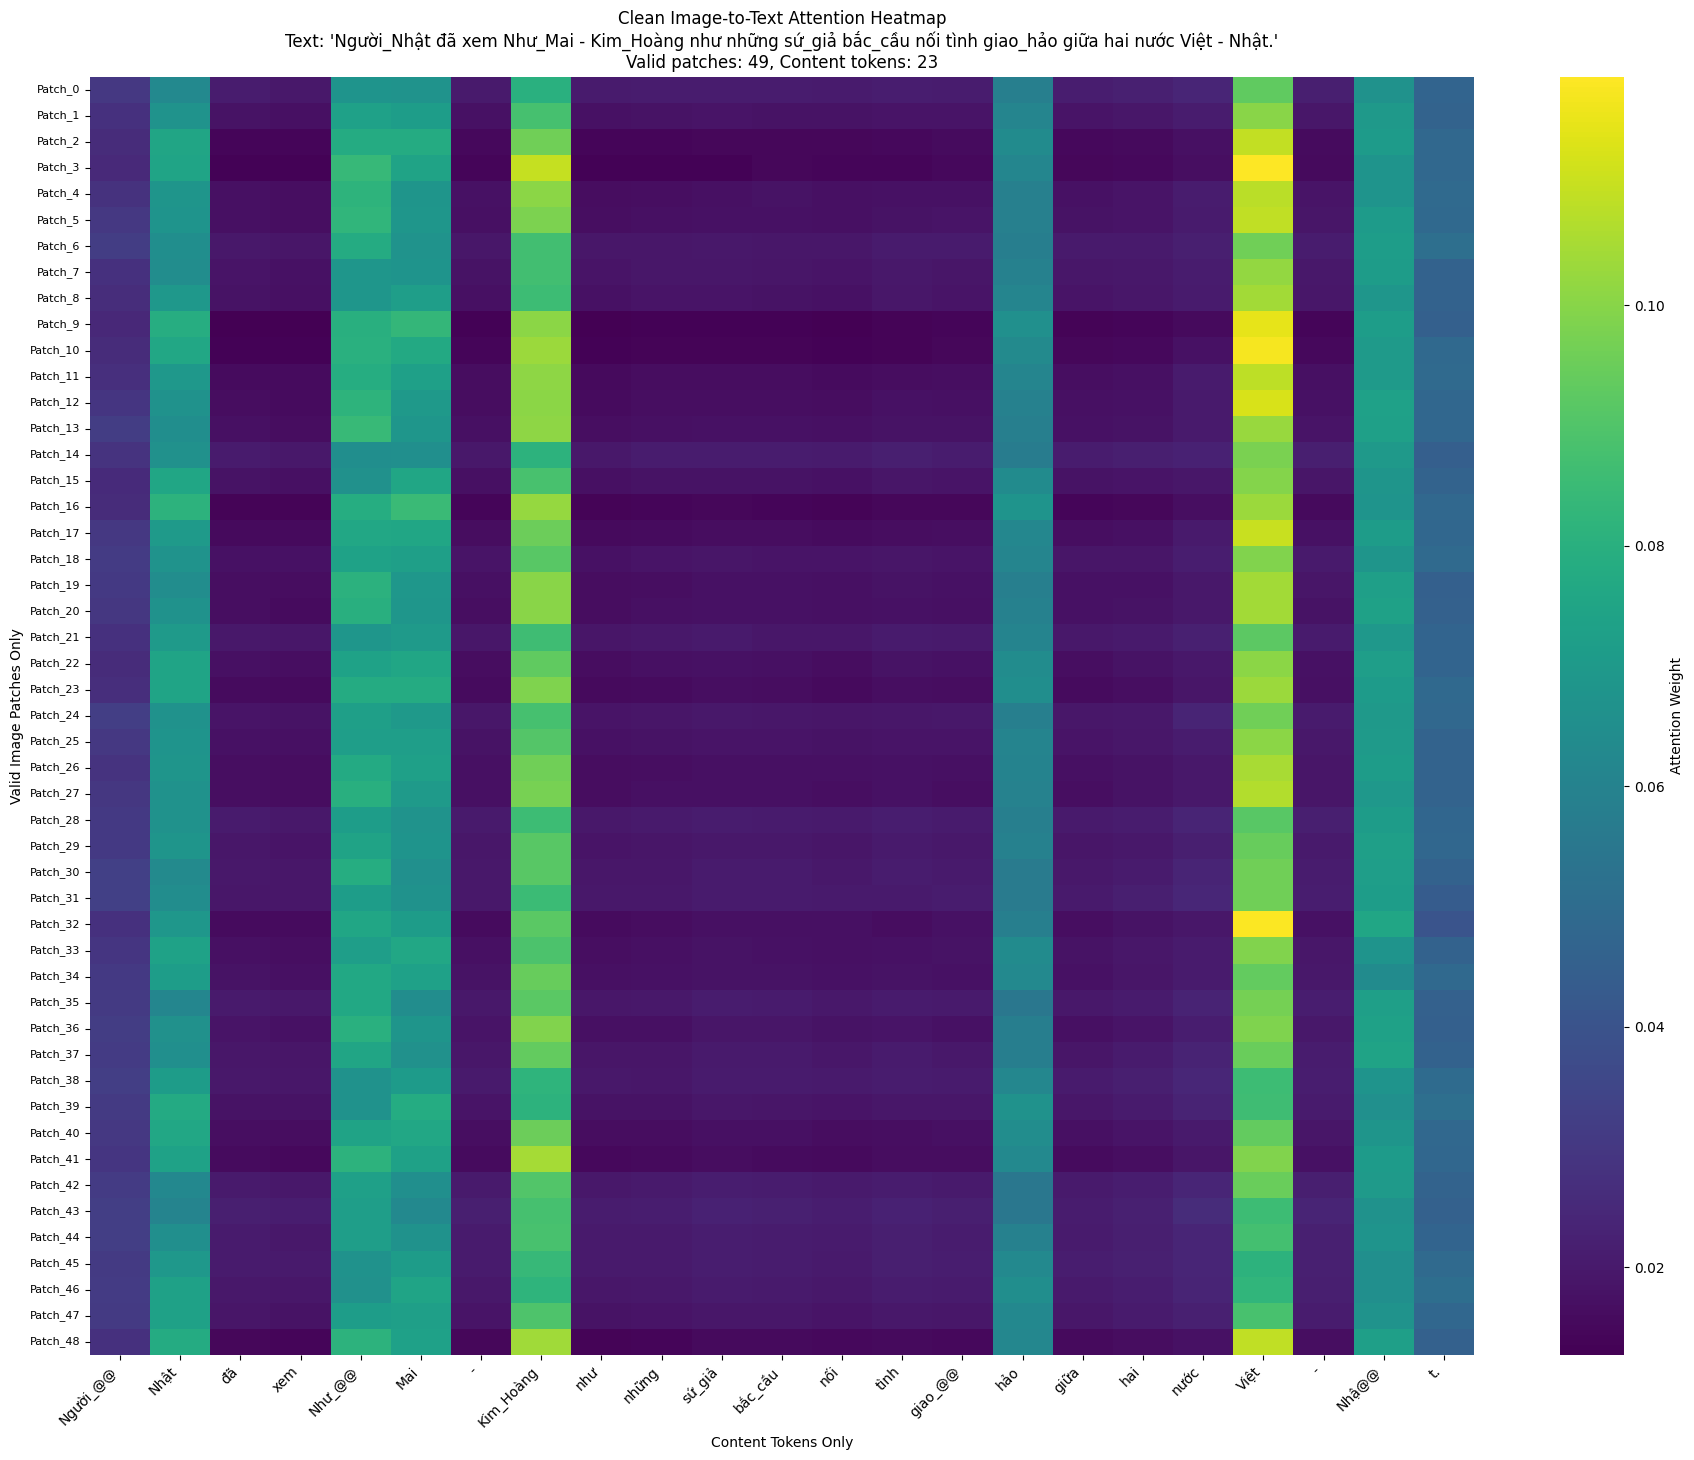

Original text: Người_Nhật đã xem Như_Mai - Kim_Hoàng như những sứ_giả bắc_cầu nối tình giao_hảo giữa hai nước Việt - Nhật.
Content tokens: ['Người_@@', 'Nhật', 'đã', 'xem', 'Như_@@', 'Mai', '-', 'Kim_Hoàng', 'như', 'những', 'sứ_giả', 'bắc_cầu', 'nối', 'tình', 'giao_@@', 'hảo', 'giữa', 'hai', 'nước', 'Việt', '-', 'Nhậ@@', 't.']
Valid image patches: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
Final attention shape: torch.Size([49, 23])


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention_heatmap(attention_weights, s1_tokens=None, s2_tokens=None, title="Attention Heatmap", save_path=None):
    """
    Visualize attention weights as a heatmap
    
    Args:
        attention_weights: Tensor of shape [batch_size, num_heads, seq_len1, seq_len2]
        s1_tokens: List of tokens for the first sequence (optional)
        s2_tokens: List of tokens for the second sequence (optional)
        title: Title for the plot
        save_path: Path to save the plot (optional)
    """
    # Average over all heads if multi-head attention
    if len(attention_weights.shape) == 4:  # [batch, heads, seq1, seq2]
        attention_weights = attention_weights.mean(dim=1)  # Average over heads
    
    # Take first batch if batched
    if len(attention_weights.shape) == 3:  # [batch, seq1, seq2]
        attention_weights = attention_weights[0]
    
    attention_weights = attention_weights.cpu().detach().numpy()
    
    plt.figure(figsize=(12, 8))
    print("s2_tokens:", s2_tokens)
    # Create heatmap
    ax = sns.heatmap(
        attention_weights,
        xticklabels=s2_tokens if s2_tokens else [f"Img_{i}" for i in range(attention_weights.shape[1])],
        yticklabels=s1_tokens if s1_tokens else [f"Txt_{i}" for i in range(attention_weights.shape[0])],
        cmap='viridis',
        cbar_kws={'label': 'Attention Weight'}
    )
    
    plt.title(title)
    plt.xlabel('Image Patches')
    plt.ylabel('Text Tokens')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def get_attention_weights(model, input_ids, segment_ids, input_mask, added_attention_mask, 
                         visual_embeds_mean, visual_embeds_att, trans_matrix, 
                         image_decode=None, alpha=None, beta=None, theta=None, sigma=None, 
                         temp=None, temp_lamb=None, labels=None, auxlabels=None):
    """
    Get attention weights from img2txt_attention module
    """
    # Get the emission scores from the BiLSTM
    features = model.roberta(input_ids, token_type_ids=segment_ids, attention_mask=input_mask)
    sequence_output = features["last_hidden_state"]
    pooler_output = features["pooler_output"]
    sequence_output = model.dropout(sequence_output)
    pooler_output = model.linear(pooler_output)

    extended_txt_mask = input_mask.unsqueeze(1).unsqueeze(2)
    extended_txt_mask = extended_txt_mask.to(dtype=next(model.parameters()).dtype)
    extended_txt_mask = (1.0 - extended_txt_mask) * -10000.0
    aux_addon_sequence_encoder = model.self_attention(sequence_output, extended_txt_mask)

    aux_addon_sequence_output = aux_addon_sequence_encoder[-1]
    aux_addon_sequence_output = aux_addon_sequence_output[0]

    main_addon_sequence_encoder = model.self_attention_v2(sequence_output, extended_txt_mask)
    main_addon_sequence_output = main_addon_sequence_encoder[-1]
    main_addon_sequence_output = main_addon_sequence_output[0]
    
    vis_embed_map = visual_embeds_att.view(-1, 2048, 49).permute(0, 2, 1)
    converted_vis_embed_map = model.vismap2text(vis_embed_map)

    # Apply txt2img attention mechanism
    img_mask = added_attention_mask[:,:49]
    extended_img_mask = img_mask.unsqueeze(1).unsqueeze(2)
    extended_img_mask = extended_img_mask.to(dtype=next(model.parameters()).dtype)
    extended_img_mask = (1.0 - extended_img_mask) * -10000.0

    cross_encoder = model.txt2img_attention(main_addon_sequence_output, converted_vis_embed_map, extended_img_mask)
    cross_output_layer = cross_encoder[-1]

    # Get attention weights from img2txt_attention
    converted_vis_embed_map_v2 = model.vismap2text_v2(vis_embed_map)
    
    # Modify the forward call to get attention weights
    cross_txt_encoder, attention_weights = model.img2txt_attention(
        converted_vis_embed_map_v2, main_addon_sequence_output, extended_txt_mask, 
        output_attentions=True
    )
    cross_txt_output_layer = cross_txt_encoder[-1]
    
    return attention_weights  # List of attention weights for each layer

import os
import torch
from PIL import Image
from torchvision import transforms
from transformers import AutoTokenizer
from modules.model_architecture.UMT_PixelCNN import UMT_PixelCNN
from transformers import AutoTokenizer, RobertaConfig
from modules.resnet import resnet as resnet
from modules.resnet.resnet_utils import myResnet
import numpy as np
import json
# === Đường dẫn ===
output_dir = "/home/vms/bags/MNER-Vietnamese/tmp/train_umt_pixelcnn_fixedlr_2016_beta0.5_theta0.05_sigma0.005_lr3e-5_fixcrf"
model_config_path = os.path.join(output_dir, "model_config.json")
model_path = os.path.join(output_dir, "pytorch_model.bin")
encoder_path = os.path.join(output_dir, "pytorch_encoder.bin")

# === Tải cấu hình từ file ===
with open(model_config_path, "r", encoding="utf-8") as f:
    model_config = json.load(f)

bert_model_name = model_config["bert_model"]
max_seq_length = model_config["max_seq_length"]
num_labels = model_config["num_labels"]  # 13
do_lower = model_config["do_lower"]  # False
label_map_from_file = model_config["label_map"]  # dict: {"1": "B-ORG", ...}

# Xây dựng label_list theo index (1 → 12)
label_list = [""] * (num_labels - 1)  # vì num_labels = 13 → có 12 nhãn thực
for str_id, label in label_map_from_file.items():
    idx = int(str_id) - 1  # vì label_map bắt đầu từ 1, nhưng list bắt đầu từ 0
    label_list[idx] = label

# Sắp xếp lại theo thứ tự index (đảm bảo label_list[i] = nhãn có id = i+1)
# Ví dụ: label_list[0] = "B-ORG" (vì id=1), label_list[7] = "O" (vì id=8)
# Nhưng ta cần danh sách theo thứ tự id tăng dần → đã đúng do vòng lặp trên gán theo idx

# Tuy nhiên, để an toàn, ta tạo lại từ dict:
label_list = []
for i in range(1, num_labels):  # 1 đến 12
    label_list.append(label_map_from_file[str(i)])

# === Giả định auxlabel_list (bạn cần kiểm tra, nhưng thường là 6 hoặc 7) ===
# Dựa trên code train: auxnum_labels = len(auxlabel_list) + 1 = 7 → auxlabel_list có 6 phần tử
auxlabel_list = ["O", "B", "I", "X", "<s>", "</s>"]
auxnum_labels = len(auxlabel_list) + 1  # 7

# === Thiết lập device ===
device = "cuda" if torch.cuda.is_available() else "cpu"

# === Khởi tạo mô hình ===
config = RobertaConfig.from_pretrained(bert_model_name, cache_dir='cache')
model = UMT_PixelCNN(config, num_labels_=num_labels, auxnum_labels=auxnum_labels)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# === Encoder ảnh ===
net = getattr(resnet, 'resnet152')()
encoder = myResnet(net, if_fine_tune=False, device=device)
encoder.load_state_dict(torch.load(encoder_path, map_location=device))
encoder.to(device)
encoder.eval()

# === Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(bert_model_name, do_lower_case=do_lower)

# === Image transforms (giống training) ===
crop_size = 224
ti_crop_size = 32

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_for_ti = transforms.Compose([
    transforms.Resize([ti_crop_size, ti_crop_size]),
    transforms.ToTensor(),
    transforms.Normalize((0.48, 0.498, 0.531), (0.214, 0.207, 0.207))
])

def image_process(image_path, transform):
    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image)
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        # fallback to background
        bg_path = "/home/vms/bags/vlsp_all/origin+image/VLSP2016/ner_image/background.jpg"
        if not os.path.exists(bg_path):
            # tạo ảnh đen nếu không có background.jpg
            image = Image.new("RGB", (256, 256), (0, 0, 0))
        else:
            image = Image.open(bg_path).convert("RGB")
        return transform(image)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention_heatmap_clean(attention_weights, text_tokens=None, title="Attention Heatmap", save_path=None):
    """
    Visualize attention weights with actual tokens (no padding, no special tokens)
    """
    # Average over all heads if multi-head attention
    if len(attention_weights.shape) == 4:  # [batch, heads, seq1, seq2]
        attention_weights = attention_weights.mean(dim=1)  # Average over heads
    
    # Take first batch if batched
    if len(attention_weights.shape) == 3:  # [batch, seq1, seq2]
        attention_weights = attention_weights[0]
    
    attention_weights = attention_weights.cpu().detach().numpy()
    
    plt.figure(figsize=(15, 10))
    
    # Create heatmap
    ax = sns.heatmap(
        attention_weights,
        xticklabels=text_tokens if text_tokens else [f"Token_{i}" for i in range(attention_weights.shape[1])],
        yticklabels=[f"Patch_{i}" for i in range(attention_weights.shape[0])],
        cmap='viridis',
        cbar_kws={'label': 'Attention Weight'},
        annot=False,
        fmt='.2f'
    )
    
    plt.title(title)
    plt.xlabel('Text Tokens (No Padding)')
    plt.ylabel('Image Patches')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=6)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def infer_with_complete_cleaning(text: str, image_path: str):
    # 1. Tiền xử lý ảnh
    img_feat = image_process(image_path, transform).unsqueeze(0).to(device)
    img_ti_feat = image_process(image_path, transform_for_ti).unsqueeze(0).to(device)

    # 2. Tokenize như training: từng từ
    words = text.strip().split()
    tokens = []
    original_tokens = []
    
    for word in words:
        tokenized = tokenizer.tokenize(word)
        tokens.extend(tokenized)
        original_tokens.extend(tokenized)

    # Thêm <s>, </s> cho mô hình
    full_tokens = ["<s>"] + tokens + ["</s>"]
    original_tokens_for_display = ["<s>"] + original_tokens + ["</s>"]
    
    if len(full_tokens) > max_seq_length:
        full_tokens = full_tokens[:max_seq_length]
        original_tokens_for_display = original_tokens_for_display[:max_seq_length]

    input_ids = tokenizer.convert_tokens_to_ids(full_tokens)
    segment_ids = [0] * len(input_ids)
    input_mask = [1] * len(input_ids)
    added_input_mask = [1] * (len(input_ids) + 49)  # 49 là số image patches

    # Padding
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        segment_ids.append(0)
        input_mask.append(0)
        added_input_mask.append(0)  # Padding cho cả phần text mask

    # Chuyển sang tensor
    input_ids = torch.tensor([input_ids], dtype=torch.long).to(device)
    segment_ids = torch.tensor([segment_ids], dtype=torch.long).to(device)
    input_mask = torch.tensor([input_mask], dtype=torch.long).to(device)
    added_input_mask = torch.tensor([added_input_mask], dtype=torch.long).to(device)

    # Trích xuất đặc trưng ảnh
    with torch.no_grad():
        imgs_f, img_mean, img_att = encoder(img_feat)

    # Tạo trans_matrix
    trans_matrix = np.zeros((auxnum_labels, num_labels), dtype=float)
    trans_matrix[0,0] = 1   # pad → pad
    trans_matrix[1,1] = 1   # O → O
    trans_matrix[2,2] = 0.25  # B → B-MISC
    trans_matrix[2,4] = 0.25  # B → B-PER
    trans_matrix[2,6] = 0.25  # B → B-ORG
    trans_matrix[2,8] = 0.25  # B → B-LOC
    trans_matrix[3,3] = 0.25  # I → I-MISC
    trans_matrix[3,5] = 0.25  # I → I-PER
    trans_matrix[3,7] = 0.25  # I → I-ORG
    trans_matrix[3,9] = 0.25  # I → I-LOC
    trans_matrix[4,10] = 1    # X → X
    trans_matrix[5,11] = 1    # <s> → <s>
    trans_matrix[6,12] = 1    # </s> → </s>
    trans_matrix = torch.tensor(trans_matrix, dtype=torch.float).to(device)

    # Get attention weights
    attention_weights = get_attention_weights(
        model, input_ids, segment_ids, input_mask, added_input_mask, 
        imgs_f, img_att, trans_matrix
    )

    if attention_weights:
        layer_0_attention = attention_weights[0]  # Shape: [1, num_heads, 49, seq_len]
        
        # Lọc ra các token thực sự có nội dung (không phải special token, không phải padding)
        content_token_positions = []
        content_tokens_for_display = []
        
        for i, (token, mask_val) in enumerate(zip(original_tokens_for_display, input_mask[0].cpu().numpy())):
            if mask_val == 1 and token not in ['<pad>', '<s>', '</s>']:  # Loại bỏ padding và special tokens
                content_token_positions.append(i)
                content_tokens_for_display.append(token)
        
        # Trong kiến trúc hiện tại, image patches thường không bị padding
        # added_input_mask[0, :49] là mask cho 49 image patches
        # Trong hầu hết trường hợp, tất cả 49 patches đều được sử dụng (mask = 1)
        # Nhưng nếu có padding trong image patches, ta có thể lọc như sau:
        
        image_patch_mask = added_input_mask[0, :49].cpu().numpy()  # Lấy mask cho image patches
        valid_image_patches = []
        for i in range(49):
            if image_patch_mask[i] == 1:  # Nếu patch không bị mask
                valid_image_patches.append(i)
        
        print(f"Valid image patches: {len(valid_image_patches)}/49")
        print(f"Valid text tokens: {len(content_token_positions)}/{len(original_tokens_for_display)}")
        
        # Cắt attention weights theo cả image patches và content tokens
        if content_token_positions and valid_image_patches:
            # Cắt theo cả image patches và text tokens
            clean_attention = layer_0_attention[:, :, valid_image_patches, :][:, :, :, content_token_positions].squeeze(0)
            # Shape sau khi cắt: [num_heads, num_valid_patches, num_content_tokens]
            
            # Average over heads
            clean_attention = clean_attention.mean(dim=0)  # Shape: [num_valid_patches, num_content_tokens]
            
            # Tạo labels cho visualization
            patch_labels = [f"Patch_{i}" for i in valid_image_patches]
            
            # Visualize
            plt.figure(figsize=(max(12, len(content_tokens_for_display) * 0.8), max(8, len(valid_image_patches) * 0.3)))
            
            ax = sns.heatmap(
                clean_attention.cpu().detach().numpy(),
                xticklabels=content_tokens_for_display,
                yticklabels=patch_labels,
                cmap='viridis',
                cbar_kws={'label': 'Attention Weight'},
                annot=False,
                fmt='.2f'
            )
            
            plt.title(f"Clean Image-to-Text Attention Heatmap\nText: '{text}'\nValid patches: {len(valid_image_patches)}, Content tokens: {len(content_tokens_for_display)}")
            plt.xlabel('Content Tokens Only')
            plt.ylabel('Valid Image Patches Only')
            plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.yticks(rotation=0, fontsize=8)
            plt.tight_layout()
            
            plt.savefig("fully_clean_img2txt_attention_heatmap.png", dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"Original text: {text}")
            print(f"Content tokens: {content_tokens_for_display}")
            print(f"Valid image patches: {valid_image_patches}")
            print(f"Final attention shape: {clean_attention.shape}")
            
            return clean_attention, content_tokens_for_display, valid_image_patches
        else:
            print("No valid content tokens or image patches found!")
            return None, None, None

# === Chạy ví dụ ===
if __name__ == "__main__":
    text = "Người_Nhật đã xem Như_Mai - Kim_Hoàng như những sứ_giả bắc_cầu nối tình giao_hảo giữa hai nước Việt - Nhật."
    image_path = "/home/vms/bags/vlsp_all/origin+image/VLSP2016/ner_image/018378.jpg"
    
    attention_matrix, tokens_display, patches_display = infer_with_complete_cleaning(text, image_path)

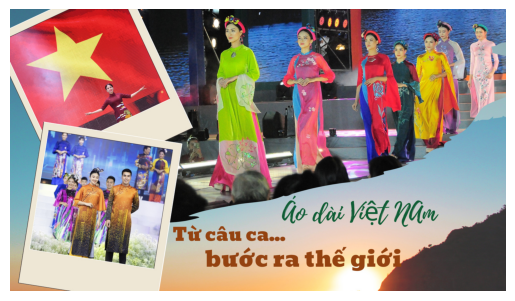

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

# Đường dẫn tới ảnh
image_path = "/home/vms/bags/vlsp_all/origin+image/VLSP2016/ner_image/018378.jpg"

# Mở ảnh
img = Image.open(image_path)

# Hiển thị ảnh
plt.imshow(img)
plt.axis('off')  # Tắt trục tọa độ
plt.show()